In [4]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from saif.crs_model.peakdetector import pk_indxs
plt.style.use('ggplot')

%matplotlib inline

### Load Data

In [5]:
SEISMIC_DATA = '../../../dataset_preparing/datasets_Jul_7/cushing_oklahoma/cushingSeismic.hdf5'
PRESSURE_DATA = '../../../dataset_preparing/datasets_Jul_7/cushing_oklahoma/cushingPressure.hdf5'

In [6]:
from orion_light import seismic_catalog
from orion_light import pressure_table

In [7]:
catalog = seismic_catalog.SeismicCatalog()
catalog.load_catalog_hdf5(SEISMIC_DATA)

In [8]:
pressure_model = pressure_table.PressureTableModel()
pressure_model.load_table(PRESSURE_DATA)

Loading pressure table from hdf5 file: ../../../dataset_preparing/datasets_Jul_7/cushing_oklahoma/cushingPressure.hdf5


### Process $N(t)$

- Pressure data and seismic events are recorded at different times.
    - First goal: Clip all data to the time interval where we have samples for both pressure and seismic activity
    - Second goal: linearly interpolate the seismic data so that the event times align with the pressure data.
    - Third goal: empirically compute the rate (numerical derivative), in order to define R0.
- Partition the data into **main shock** and **interseismic** regions.
    - This should be done by a peak detector, but right now it is done manually (by visual inspection).

In [9]:
from scipy.interpolate import interp1d

Obtain the time intervals for the seismic data, and creating the interpolator.

In [10]:
Mc = 1.6
catalog.set_slice(magnitude_range = [Mc, 10])
event_times = catalog.get_epoch_slice() 
start_t = event_times[0]
end_t = event_times[-1]
event_times = event_times / 86400 / 365.25

t_n = event_times - event_times[0]
n_cnts = np.arange(len(t_n))
n_func = interp1d(t_n, n_cnts, kind='linear')

Obtain the time intervals for the pressure data, and interpolate the seismic data

In [11]:
t_p = pressure_epoch = pressure_model.table_data['t']
start_idx = np.where(t_p > start_t)[0][0]
end_idx = np.where(t_p > end_t)[0][0] - 1

t_p = t_p[start_idx:end_idx]
p = pressure_model.table_data['pressure'][1:][start_idx+1:end_idx]
dpdt = pressure_model.table_data['dpdt'][1:][start_idx+1:end_idx]

delta_t = t_p[1:] - t_p[:-1]

p = torch.FloatTensor(p)
dpdt = torch.FloatTensor(dpdt)
delta_t = torch.FloatTensor(delta_t)

t_p_interpolated = t_p / 86400 / 365.25 - event_times[0]
n_interpolated = n_func(t_p_interpolated) # interpolated number of earthquakes 

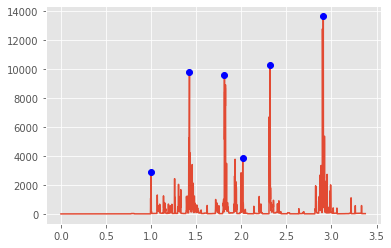

In [12]:
empirical_rate = np.gradient(n_interpolated, t_p_interpolated)
peak_indexs=pk_indxs(empirical_rate,trshd=0.2, min_dist=150)
plt.plot(t_p_interpolated, empirical_rate)
plt.plot(t_p_interpolated[peak_indexs],empirical_rate[peak_indexs],'o',color='b')

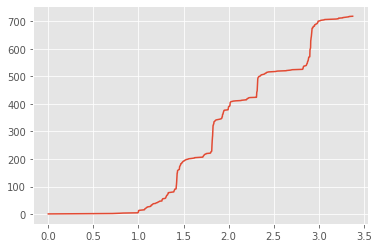

In [13]:
plt.plot(t_p_interpolated, n_interpolated)

Examining the first interseismic chunk (from t=0 years to t=1.3 years)

In [14]:
train_end = np.where(t_p_interpolated > 1.3)[0][0]

In [15]:
n_target = torch.FloatTensor(n_interpolated)[:train_end]
p = torch.FloatTensor(p)[:train_end]
dpdt = torch.FloatTensor(dpdt)[:train_end]
delta_t = torch.FloatTensor(delta_t)[:train_end]

### Define site constants

In [16]:
mpa_yr2pa_s = 1e6 / 365.25 / 86400

site_info = {
    'tectonic_shear_stressing_rate' : 3.5e-4 * mpa_yr2pa_s, # Pa / s
    'tectonic_normal_stressing_rate' : 0, # Pa/s
    'sigma' : 30 * 1e6, # Pa
    'biot' : 0.3, # dimensionless
    #'background_rate' : 1.36 / 365.25 / 86400, # event/second,
    'background_rate' : empirical_rate[0] / 365.25 / 86400, # event/second,
    'init_delta_t' : delta_t[0].item()
}

### Sampling the grid

We keep the rate factor fixed, and examine the landscape for mu_minus_alpha and rate_coeff.

In [17]:
params = torch.FloatTensor([[0.5,1e-2,1e-4]])


# mu_minus_alpha_mesh = torch.linspace(0.1,1.0,101)
# rate_coeff_mesh = 10 ** torch.linspace(-4,-1,101)
# grid_mu, grid_rate = torch.meshgrid(mu_minus_alpha_mesh, rate_coeff_mesh, indexing='ij')

# params = torch.stack([
#     grid_mu.flatten(),
#     grid_rate.flatten(),
#     163.7424 / 1e6 * torch.ones_like(grid_rate.flatten()), # rate_factor 
# ]).T

# params.requires_grad_()



tensor([[1.0000e-01, 1.0000e-04, 1.6374e-04],
        [1.0000e-01, 1.0715e-04, 1.6374e-04],
        [1.0000e-01, 1.1482e-04, 1.6374e-04],
        ...,
        [1.0000e+00, 8.7096e-02, 1.6374e-04],
        [1.0000e+00, 9.3325e-02, 1.6374e-04],
        [1.0000e+00, 1.0000e-01, 1.6374e-04]], requires_grad=True)

### Run Model

In [18]:
from saif.crs_model.model import CRSModel

In [19]:
model = CRSModel(site_info)

In [20]:
Rt, Nt = model(params, p, dpdt, delta_t)

In [21]:
Rt

tensor([[4.9332e-08, 4.9384e-08, 4.9436e-08,  ..., 1.0137e-06, 1.0163e-06,
         1.0190e-06],
        [4.9332e-08, 4.9380e-08, 4.9429e-08,  ..., 1.0107e-06, 1.0133e-06,
         1.0160e-06],
        [4.9332e-08, 4.9377e-08, 4.9422e-08,  ..., 1.0076e-06, 1.0102e-06,
         1.0129e-06],
        ...,
        [4.9332e-08, 4.9334e-08, 4.9336e-08,  ..., 7.8315e-08, 7.8372e-08,
         7.8429e-08],
        [4.9332e-08, 4.9334e-08, 4.9336e-08,  ..., 7.5940e-08, 7.5991e-08,
         7.6043e-08],
        [4.9332e-08, 4.9334e-08, 4.9336e-08,  ..., 7.3788e-08, 7.3835e-08,
         7.3882e-08]], grad_fn=<CatBackward0>)

In [23]:
Nt.shape

torch.Size([10201, 1415])

Visualize a sample

Define the criterion: MSELoss.

- Be careful: we may need to normalize the data before using MSELoss.
- In future, we might forecast rate (or, $\Delta N(t)$) since this is easier to bound than total number.

In [24]:
criterion = nn.MSELoss(reduction='sum')

In [50]:
loss = criterion(Nt[:,1:], n_target[None,:])
loss.item()

/opt/anaconda3/envs/kedro-environment/lib/python3.7/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 1414])) that is different to the input size (torch.Size([10201, 1414])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


7804534784.0

In [36]:
loss.backward()

In [37]:
params.grad.data

tensor([[  -102473.8906,   4753363.0000, -37033184.0000]])

In [25]:
import torch.optim as optim
optimizer = optim.SGD(params=[params],lr=0.1,momentum=0.9)
criterion = nn.MSELoss(reduction='sum')

params = torch.FloatTensor([[0.5,1e-2,1e-4]])
params.requires_grad=True

model = CRSModel(site_info)
Rt, Nt = model(params, p, dpdt, delta_t)

In [36]:
for epoch in range(5):
    model = CRSModel(site_info)
    Rt, Nt = model(params, p, dpdt, delta_t)
    # loss = criterion(Nt[:,1:], n_target[None,:]) # Need to define a loss function that compares with the real data
    # Define a MSE of forecasted number Nt with the ground truth
    loss = criterion(Nt[:,1:], n_target)
    print('loss is ' + str(loss.item()))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

/opt/anaconda3/envs/kedro-environment/lib/python3.7/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1414])) that is different to the input size (torch.Size([1, 1414])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss is 364191.0
loss is 364191.0
loss is 364191.0
loss is 364191.0
loss is 364191.0


In [28]:
Nt.shape

torch.Size([1, 1415])

In [32]:
n_target.shape


torch.Size([1414])